<a href="https://colab.research.google.com/github/atultiwari/yolov8-cam/blob/main/YOLOv8_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/atultiwari/yolov8-cam.git

Cloning into 'yolov8-cam'...
remote: Enumerating objects: 589, done.
remote: Counting objects: 100% (589/589), done.
remote: Compressing objects: 100% (577/577), done.
remote: Total 589 (delta 7), reused 582 (delta 5), pack-reused 0
Receiving objects: 100% (589/589), 25.05 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
%cd yolov8-cam

/content/yolov8-cam


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
model_weight = "/content/yolov8-cam/runs/detect/train/weights/best.pt"
test_image = "/content/yolov8-cam/datasets/wbc/test/images/LY_16036_jpg.rf.f845db465113edb12af8c6ce1e80d48a.jpg"

In [5]:
import ultralytics
ultralytics.__version__

'8.2.66'

In [6]:
from ultralytics import YOLO
from IPython.display import display, Image

In [7]:
!yolo task=detect mode=predict model=/content/yolov8-cam/runs/detect/train/weights/best.pt conf=0.25 source=/content/yolov8-cam/datasets/wbc/test/images/LY_16036_jpg.rf.f845db465113edb12af8c6ce1e80d48a.jpg save=True

Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/yolov8-cam/datasets/wbc/test/images/LY_16036_jpg.rf.f845db465113edb12af8c6ce1e80d48a.jpg: 800x800 1 lymphocyte, 1 platelet, 70.5ms
Speed: 17.8ms preprocess, 70.5ms inference, 2027.1ms postprocess per image at shape (1, 3, 800, 800)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


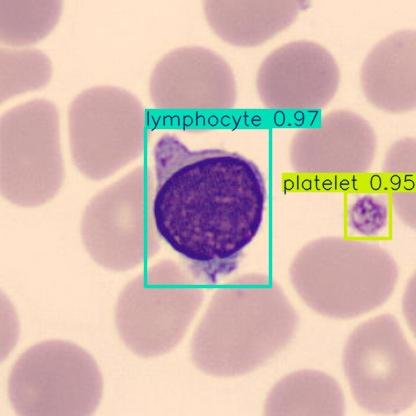

In [8]:
Image(filename=f'/content/yolov8-cam/runs/detect/predict/LY_16036_jpg.rf.f845db465113edb12af8c6ce1e80d48a.jpg', width=600)

## Install `pytorch-gradcam`

In [ ]:
# !pip install pytorch-gradcam

## Install `grad-cam`

In [9]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38336 sha256=50f6940d7fec9cf4e16e87bc376f9e7182248d3fc3fc1e5be7a3e8570bdab7f7
  Stored in directory: /root/.cache/pip/wheels/b4/68/bb/d10381e86dc0de1c9354bce3d86bffcd247305058c40ce2e55
Successfully built grad-cam


## Experiment - 1

#### Following code is copied and adapted from -
[https://github.com/z1069614715/objectdetection_script/blob/master/yolo-gradcam/yolov8_heatmap.py](https://github.com/z1069614715/objectdetection_script/blob/master/yolo-gradcam/yolov8_heatmap.py)

#### Following changes are done in the original code -


* Changed the `weight` in `get_params` function
* Changed the `image` in `__main__`
* Changed the line -
`colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(np.int)`
to -
`colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(int)` because `np.int` is deprecated
* Changed the line - `method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')` to `method = eval(method)(model, target_layers)`

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch, yaml, cv2, os, shutil, sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.utils.torch_utils import intersect_dicts
from ultralytics.utils.ops import xywh2xyxy, non_max_suppression
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def post_process(self, result):
        logits_ = result[:, 4:]
        boxes_ = result[:, :4]
        sorted, indices = torch.sort(logits_.max(1)[0], descending=True)
        return torch.transpose(logits_[0], dim0=0, dim1=1)[indices[0]], torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]], xywh2xyxy(torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]]).cpu().detach().numpy()

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        model_output = self.model(x)
        post_result, pre_post_boxes, post_boxes = self.post_process(model_output[0])
        return [[post_result, pre_post_boxes]]

    def release(self):
        for handle in self.handles:
            handle.remove()

class yolov8_target(torch.nn.Module):
    def __init__(self, ouput_type, conf, ratio) -> None:
        super().__init__()
        self.ouput_type = ouput_type
        self.conf = conf
        self.ratio = ratio

    def forward(self, data):
        post_result, pre_post_boxes = data
        result = []
        for i in trange(int(post_result.size(0) * self.ratio)):
            if float(post_result[i].max()) < self.conf:
                break
            if self.ouput_type == 'class' or self.ouput_type == 'all':
                result.append(post_result[i].max())
            elif self.ouput_type == 'box' or self.ouput_type == 'all':
                for j in range(4):
                    result.append(pre_post_boxes[i, j])
        return sum(result)

class yolov8_heatmap:
    def __init__(self, weight, device, method, layer, backward_type, conf_threshold, ratio, show_box, renormalize):
        device = torch.device(device)
        ckpt = torch.load(weight)
        model_names = ckpt['model'].names
        model = attempt_load_weights(weight, device)
        model.info()
        for p in model.parameters():
            p.requires_grad_(True)
        model.eval()

        target = yolov8_target(backward_type, conf_threshold, ratio)
        target_layers = [model.model[l] for l in layer]
        # method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')
        method = eval(method)(model, target_layers)
        method.activations_and_grads = ActivationsAndGradients(model, target_layers, None)

        colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(int)
        self.__dict__.update(locals())

    def post_process(self, result):
        result = non_max_suppression(result, conf_thres=self.conf_threshold, iou_thres=0.65)[0]
        return result

    def draw_detections(self, box, color, name, img):
        xmin, ymin, xmax, ymax = list(map(int, list(box)))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), tuple(int(x) for x in color), 2)
        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, tuple(int(x) for x in color), 2, lineType=cv2.LINE_AA)
        return img

    def renormalize_cam_in_bounding_boxes(self, boxes, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1]
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(grayscale_cam.shape[1] - 1, x2), min(grayscale_cam.shape[0] - 1, y2)
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        return eigencam_image_renormalized

    def process(self, img_path, save_path):
        # img process
        img = cv2.imread(img_path)
        img = letterbox(img)[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255.0
        tensor = torch.from_numpy(np.transpose(img, axes=[2, 0, 1])).unsqueeze(0).to(self.device)

        try:
            grayscale_cam = self.method(tensor, [self.target])
        except AttributeError as e:
            return

        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        pred = self.model(tensor)[0]
        pred = self.post_process(pred)
        if self.renormalize:
            cam_image = self.renormalize_cam_in_bounding_boxes(pred[:, :4].cpu().detach().numpy().astype(np.int32), img, grayscale_cam)
        if self.show_box:
            for data in pred:
                data = data.cpu().detach().numpy()
                cam_image = self.draw_detections(data[:4], self.colors[int(data[4:].argmax())], f'{self.model_names[int(data[4:].argmax())]} {float(data[4:].max()):.2f}', cam_image)

        cam_image = Image.fromarray(cam_image)
        cam_image.save(save_path)

    def __call__(self, img_path, save_path):
        # remove dir if exist
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        # make dir if not exist
        os.makedirs(save_path, exist_ok=True)

        if os.path.isdir(img_path):
            for img_path_ in os.listdir(img_path):
                self.process(f'{img_path}/{img_path_}', f'{save_path}/{img_path_}')
        else:
            self.process(img_path, f'{save_path}/result.png')

def get_params():
    params = {
        'weight': model_weight, # 现在只需要指定权重即可,不需要指定cfg
        'device': 'cuda:0',
        'method': 'HiResCAM', # GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
        'layer': [10, 12, 14, 16, 18],
        'backward_type': 'class', # class, box, all
        'conf_threshold': 0.2, # 0.2
        'ratio': 0.02, # 0.02-0.1
        'show_box': False,
        'renormalize': True
    }
    return params

if __name__ == '__main__':
    model = yolov8_heatmap(**get_params())
    model(test_image, 'result')
    # model(r'/home/hjj/Desktop/dataset/dataset_visdrone/VisDrone2019-DET-test-dev/images', 'result')

Model summary: 225 layers, 3,012,408 parameters, 0 gradients, 8.2 GFLOPs


 11%|█▏        | 19/168 [00:00<00:00, 5396.25it/s]


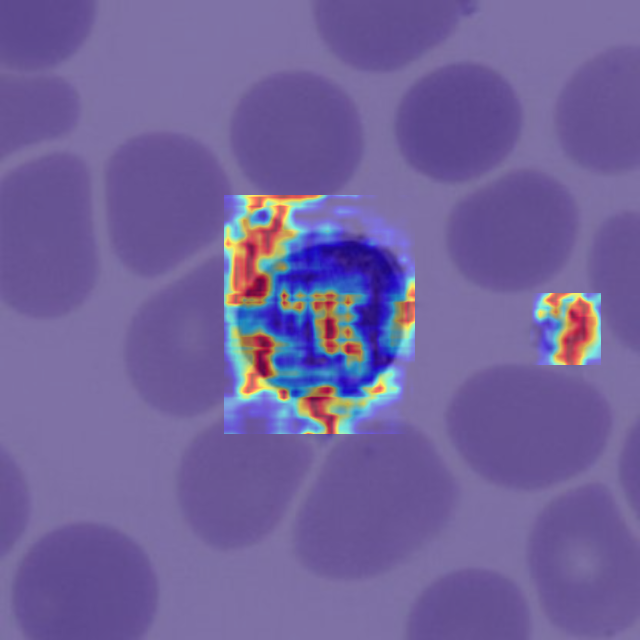

In [16]:
from IPython.display import display, Image

# Path to the image
image_path = '/content/yolov8-cam/result/result.png'

# Display the image
display(Image(filename=image_path))

## Experiment - 2

In [17]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch, yaml, cv2, os, shutil, sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.utils.torch_utils import intersect_dicts
from ultralytics.utils.ops import xywh2xyxy, non_max_suppression
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def post_process(self, result):
        logits_ = result[:, 4:]
        boxes_ = result[:, :4]
        sorted, indices = torch.sort(logits_.max(1)[0], descending=True)
        return torch.transpose(logits_[0], dim0=0, dim1=1)[indices[0]], torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]], xywh2xyxy(torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]]).cpu().detach().numpy()

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        model_output = self.model(x)
        post_result, pre_post_boxes, post_boxes = self.post_process(model_output[0])
        return [[post_result, pre_post_boxes]]

    def release(self):
        for handle in self.handles:
            handle.remove()

class yolov8_target(torch.nn.Module):
    def __init__(self, ouput_type, conf, ratio) -> None:
        super().__init__()
        self.ouput_type = ouput_type
        self.conf = conf
        self.ratio = ratio

    def forward(self, data):
        post_result, pre_post_boxes = data
        result = []
        for i in trange(int(post_result.size(0) * self.ratio)):
            if float(post_result[i].max()) < self.conf:
                break
            if self.ouput_type == 'class' or self.ouput_type == 'all':
                result.append(post_result[i].max())
            elif self.ouput_type == 'box' or self.ouput_type == 'all':
                for j in range(4):
                    result.append(pre_post_boxes[i, j])
        return sum(result)

class yolov8_heatmap:
    def __init__(self, weight, device, method, layer, backward_type, conf_threshold, ratio, show_box, renormalize):
        device = torch.device(device)
        ckpt = torch.load(weight)
        model_names = ckpt['model'].names
        model = attempt_load_weights(weight, device)
        model.info()
        for p in model.parameters():
            p.requires_grad_(True)
        model.eval()

        target = yolov8_target(backward_type, conf_threshold, ratio)
        target_layers = [model.model[l] for l in layer]
        # method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')
        method = eval(method)(model, target_layers)
        method.activations_and_grads = ActivationsAndGradients(model, target_layers, None)

        colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(int)
        self.__dict__.update(locals())

    def post_process(self, result):
        result = non_max_suppression(result, conf_thres=self.conf_threshold, iou_thres=0.65)[0]
        return result

    def draw_detections(self, box, color, name, img):
        xmin, ymin, xmax, ymax = list(map(int, list(box)))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), tuple(int(x) for x in color), 2)
        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, tuple(int(x) for x in color), 2, lineType=cv2.LINE_AA)
        return img

    def renormalize_cam_in_bounding_boxes(self, boxes, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1]
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(grayscale_cam.shape[1] - 1, x2), min(grayscale_cam.shape[0] - 1, y2)
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        return eigencam_image_renormalized

    def process(self, img_path, save_path):
        # img process
        img = cv2.imread(img_path)
        img = letterbox(img)[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255.0
        tensor = torch.from_numpy(np.transpose(img, axes=[2, 0, 1])).unsqueeze(0).to(self.device)

        try:
            grayscale_cam = self.method(tensor, [self.target])
        except AttributeError as e:
            return

        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        pred = self.model(tensor)[0]
        pred = self.post_process(pred)
        if self.renormalize:
            cam_image = self.renormalize_cam_in_bounding_boxes(pred[:, :4].cpu().detach().numpy().astype(np.int32), img, grayscale_cam)
        if self.show_box:
            for data in pred:
                data = data.cpu().detach().numpy()
                cam_image = self.draw_detections(data[:4], self.colors[int(data[4:].argmax())], f'{self.model_names[int(data[4:].argmax())]} {float(data[4:].max()):.2f}', cam_image)

        cam_image = Image.fromarray(cam_image)
        cam_image.save(save_path)

    def __call__(self, img_path, save_path):
        # remove dir if exist
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        # make dir if not exist
        os.makedirs(save_path, exist_ok=True)

        if os.path.isdir(img_path):
            for img_path_ in os.listdir(img_path):
                self.process(f'{img_path}/{img_path_}', f'{save_path}/{img_path_}')
        else:
            self.process(img_path, f'{save_path}/result.png')

def get_params():
    params = {
        'weight': model_weight, # 现在只需要指定权重即可,不需要指定cfg
        'device': 'cuda:0',
        'method': 'HiResCAM', # GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
        'layer': [10, 12, 14, 16, 18],
        'backward_type': 'class', # class, box, all
        'conf_threshold': 0.2, # 0.2
        'ratio': 0.02, # 0.02-0.1
        'show_box': True,
        'renormalize': True
    }
    return params

if __name__ == '__main__':
    model = yolov8_heatmap(**get_params())
    model(test_image, 'result')
    # model(r'/home/hjj/Desktop/dataset/dataset_visdrone/VisDrone2019-DET-test-dev/images', 'result')

Model summary: 225 layers, 3,012,408 parameters, 0 gradients, 8.2 GFLOPs


 11%|█▏        | 19/168 [00:00<00:00, 7939.01it/s]


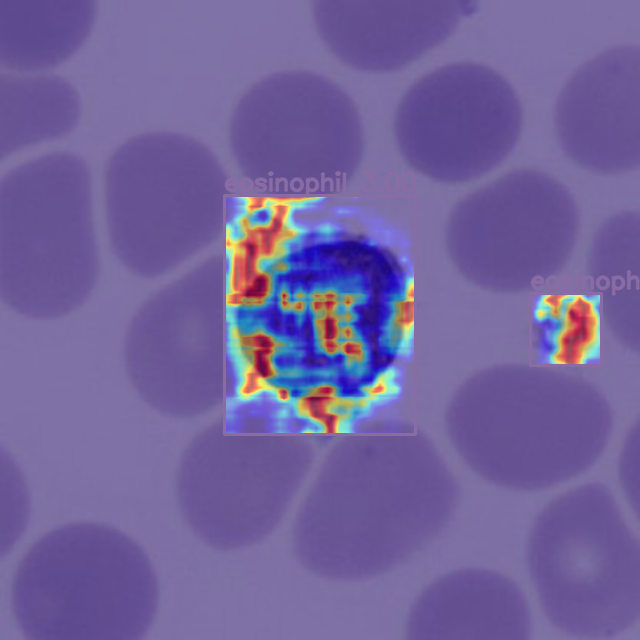

In [18]:
from IPython.display import display, Image

# Path to the image
image_path = '/content/yolov8-cam/result/result.png'

# Display the image
display(Image(filename=image_path))

## Experiment - 3

In [24]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch, yaml, cv2, os, shutil, sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.utils.torch_utils import intersect_dicts
from ultralytics.utils.ops import xywh2xyxy, non_max_suppression
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def post_process(self, result):
        logits_ = result[:, 4:]
        boxes_ = result[:, :4]
        sorted, indices = torch.sort(logits_.max(1)[0], descending=True)
        return torch.transpose(logits_[0], dim0=0, dim1=1)[indices[0]], torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]], xywh2xyxy(torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]]).cpu().detach().numpy()

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        model_output = self.model(x)
        post_result, pre_post_boxes, post_boxes = self.post_process(model_output[0])
        return [[post_result, pre_post_boxes]]

    def release(self):
        for handle in self.handles:
            handle.remove()

class yolov8_target(torch.nn.Module):
    def __init__(self, ouput_type, conf, ratio) -> None:
        super().__init__()
        self.ouput_type = ouput_type
        self.conf = conf
        self.ratio = ratio

    def forward(self, data):
        post_result, pre_post_boxes = data
        result = []
        for i in trange(int(post_result.size(0) * self.ratio)):
            if float(post_result[i].max()) < self.conf:
                break
            if self.ouput_type == 'class' or self.ouput_type == 'all':
                result.append(post_result[i].max())
            elif self.ouput_type == 'box' or self.ouput_type == 'all':
                for j in range(4):
                    result.append(pre_post_boxes[i, j])
        return sum(result)

class yolov8_heatmap:
    def __init__(self, weight, device, method, layer, backward_type, conf_threshold, ratio, show_box, renormalize):
        device = torch.device(device)
        ckpt = torch.load(weight)
        model_names = ckpt['model'].names
        model = attempt_load_weights(weight, device)
        model.info()
        for p in model.parameters():
            p.requires_grad_(True)
        model.eval()

        target = yolov8_target(backward_type, conf_threshold, ratio)
        target_layers = [model.model[l] for l in layer]
        # method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')
        method = eval(method)(model, target_layers)
        method.activations_and_grads = ActivationsAndGradients(model, target_layers, None)

        colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(int)
        self.__dict__.update(locals())

    def post_process(self, result):
        result = non_max_suppression(result, conf_thres=self.conf_threshold, iou_thres=0.65)[0]
        return result

    def draw_detections(self, box, color, name, img):
        xmin, ymin, xmax, ymax = list(map(int, list(box)))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), tuple(int(x) for x in color), 2)
        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, tuple(int(x) for x in color), 2, lineType=cv2.LINE_AA)
        return img

    def renormalize_cam_in_bounding_boxes(self, boxes, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1]
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(grayscale_cam.shape[1] - 1, x2), min(grayscale_cam.shape[0] - 1, y2)
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        return eigencam_image_renormalized

    def process(self, img_path, save_path):
        # img process
        img = cv2.imread(img_path)
        img = letterbox(img)[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255.0
        tensor = torch.from_numpy(np.transpose(img, axes=[2, 0, 1])).unsqueeze(0).to(self.device)

        try:
            grayscale_cam = self.method(tensor, [self.target])
        except AttributeError as e:
            return

        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        pred = self.model(tensor)[0]
        pred = self.post_process(pred)
        if self.renormalize:
            cam_image = self.renormalize_cam_in_bounding_boxes(pred[:, :4].cpu().detach().numpy().astype(np.int32), img, grayscale_cam)
        if self.show_box:
            for data in pred:
                data = data.cpu().detach().numpy()
                cam_image = self.draw_detections(data[:4], self.colors[int(data[4:].argmax())], f'{self.model_names[int(data[4:].argmax())]} {float(data[4:].max()):.2f}', cam_image)

        cam_image = Image.fromarray(cam_image)
        cam_image.save(save_path)

    def __call__(self, img_path, save_path):
        # remove dir if exist
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        # make dir if not exist
        os.makedirs(save_path, exist_ok=True)

        if os.path.isdir(img_path):
            for img_path_ in os.listdir(img_path):
                self.process(f'{img_path}/{img_path_}', f'{save_path}/{img_path_}')
        else:
            self.process(img_path, f'{save_path}/result.png')

def get_params():
    params = {
        'weight': model_weight, # 现在只需要指定权重即可,不需要指定cfg
        'device': 'cuda:0',
        'method': 'EigenGradCAM', # GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
        'layer': [10, 12, 14, 16, 18],
        'backward_type': 'class', # class, box, all
        'conf_threshold': 0.2, # 0.2
        'ratio': 0.02, # 0.02-0.1
        'show_box': True,
        'renormalize': True
    }
    return params

if __name__ == '__main__':
    model = yolov8_heatmap(**get_params())
    model(test_image, 'result')
    # model(r'/home/hjj/Desktop/dataset/dataset_visdrone/VisDrone2019-DET-test-dev/images', 'result')

Model summary: 225 layers, 3,012,408 parameters, 0 gradients, 8.2 GFLOPs


 11%|█▏        | 19/168 [00:00<00:00, 6828.19it/s]


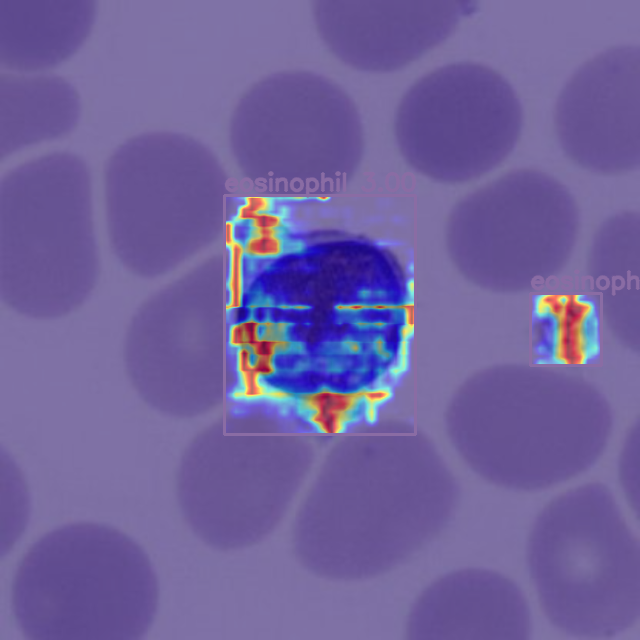

In [25]:
from IPython.display import display, Image
image_path = '/content/yolov8-cam/result/result.png'
display(Image(filename=image_path))

## Experiment - 4

In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch, yaml, cv2, os, shutil, sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.utils.torch_utils import intersect_dicts
from ultralytics.utils.ops import xywh2xyxy, non_max_suppression
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def post_process(self, result):
        logits_ = result[:, 4:]
        boxes_ = result[:, :4]
        sorted, indices = torch.sort(logits_.max(1)[0], descending=True)
        return torch.transpose(logits_[0], dim0=0, dim1=1)[indices[0]], torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]], xywh2xyxy(torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]]).cpu().detach().numpy()

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        model_output = self.model(x)
        post_result, pre_post_boxes, post_boxes = self.post_process(model_output[0])
        return [[post_result, pre_post_boxes]]

    def release(self):
        for handle in self.handles:
            handle.remove()

class yolov8_target(torch.nn.Module):
    def __init__(self, ouput_type, conf, ratio) -> None:
        super().__init__()
        self.ouput_type = ouput_type
        self.conf = conf
        self.ratio = ratio

    def forward(self, data):
        post_result, pre_post_boxes = data
        result = []
        for i in trange(int(post_result.size(0) * self.ratio)):
            if float(post_result[i].max()) < self.conf:
                break
            if self.ouput_type == 'class' or self.ouput_type == 'all':
                result.append(post_result[i].max())
            elif self.ouput_type == 'box' or self.ouput_type == 'all':
                for j in range(4):
                    result.append(pre_post_boxes[i, j])
        return sum(result)

class yolov8_heatmap:
    def __init__(self, weight, device, method, layer, backward_type, conf_threshold, ratio, show_box, renormalize):
        device = torch.device(device)
        ckpt = torch.load(weight)
        model_names = ckpt['model'].names
        model = attempt_load_weights(weight, device)
        model.info()
        for p in model.parameters():
            p.requires_grad_(True)
        model.eval()

        target = yolov8_target(backward_type, conf_threshold, ratio)
        target_layers = [model.model[l] for l in layer]
        # method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')
        method = eval(method)(model, target_layers)
        method.activations_and_grads = ActivationsAndGradients(model, target_layers, None)

        colors = np.random.uniform(0, 255, size=(len(model_names), 3)).astype(int)
        self.__dict__.update(locals())

    def post_process(self, result):
        result = non_max_suppression(result, conf_thres=self.conf_threshold, iou_thres=0.65)[0]
        return result

    def draw_detections(self, box, color, name, img):
        xmin, ymin, xmax, ymax = list(map(int, list(box)))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), tuple(int(x) for x in color), 2)
        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, tuple(int(x) for x in color), 2, lineType=cv2.LINE_AA)
        return img

    def renormalize_cam_in_bounding_boxes(self, boxes, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1]
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(grayscale_cam.shape[1] - 1, x2), min(grayscale_cam.shape[0] - 1, y2)
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        return eigencam_image_renormalized

    def process(self, img_path, save_path):
        # img process
        img = cv2.imread(img_path)
        img = letterbox(img)[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255.0
        tensor = torch.from_numpy(np.transpose(img, axes=[2, 0, 1])).unsqueeze(0).to(self.device)

        try:
            grayscale_cam = self.method(tensor, [self.target])
        except AttributeError as e:
            return

        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        pred = self.model(tensor)[0]
        pred = self.post_process(pred)
        if self.renormalize:
            cam_image = self.renormalize_cam_in_bounding_boxes(pred[:, :4].cpu().detach().numpy().astype(np.int32), img, grayscale_cam)
        if self.show_box:
            for data in pred:
                data = data.cpu().detach().numpy()
                cam_image = self.draw_detections(data[:4], self.colors[int(data[4:].argmax())], f'{self.model_names[int(data[4:].argmax())]} {float(data[4:].max()):.2f}', cam_image)

        cam_image = Image.fromarray(cam_image)
        cam_image.save(save_path)

    def __call__(self, img_path, save_path):
        # remove dir if exist
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        # make dir if not exist
        os.makedirs(save_path, exist_ok=True)

        if os.path.isdir(img_path):
            for img_path_ in os.listdir(img_path):
                self.process(f'{img_path}/{img_path_}', f'{save_path}/{img_path_}')
        else:
            self.process(img_path, f'{save_path}/result.png')

def get_params():
    params = {
        'weight': model_weight, # 现在只需要指定权重即可,不需要指定cfg
        'device': 'cuda:0',
        'method': 'EigenGradCAM', # GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
        'layer': [-2,-6],
        'backward_type': 'class', # class, box, all
        'conf_threshold': 0.2, # 0.2
        'ratio': 0.02, # 0.02-0.1
        'show_box': True,
        'renormalize': True
    }
    return params

if __name__ == '__main__':
    model = yolov8_heatmap(**get_params())
    model(test_image, 'result')
    # model(r'/home/hjj/Desktop/dataset/dataset_visdrone/VisDrone2019-DET-test-dev/images', 'result')

Model summary: 225 layers, 3,012,408 parameters, 0 gradients, 8.2 GFLOPs


 11%|█▏        | 19/168 [00:00<00:00, 5592.41it/s]


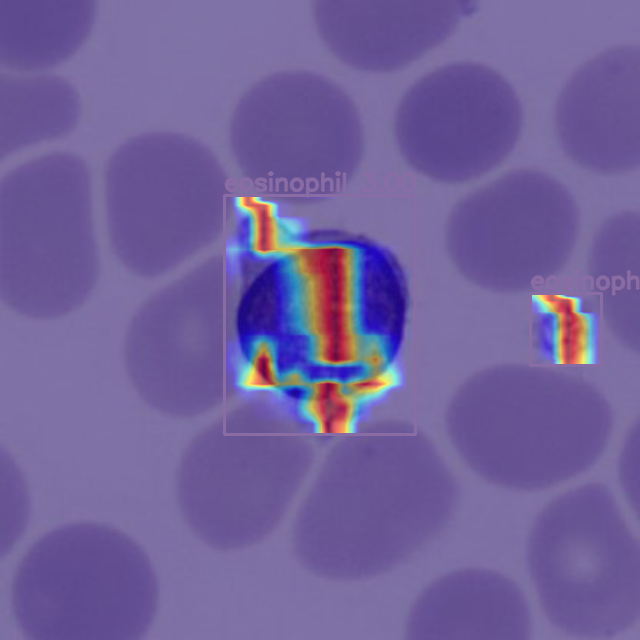

In [27]:
from IPython.display import display, Image
image_path = '/content/yolov8-cam/result/result.png'
display(Image(filename=image_path))